Modify inspect_spectra for alt binning (subject pairwise)

In [3]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/indiv_dim/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *
import argparse
from tqdm import tqdm
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

HOME_DIR = Path("/data/chan21/idim-debug-spectra")
mpl.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")


Configure spectra

In [4]:
movies = ['iteration', 'defeat', 'growth', 'lemonade']
rois = ['occipital', 'ventral', 'temporal', 'semantic', 'pmc']
rois_names = {'occipitotemporal': 'OccTC',
                'occipital': 'OccC',
              'ventral': 'VTC',
              'temporal': 'LTC',
              'semantic': 'SMC',
              'pmc': 'PMC',}
metric = 'cov'
color="magma"
roi_colors = sns.color_palette(color, 5)

# min_length = 1430
# slope = -1.6 if metric == 'cov' else -0.4
# indices = np.arange(1, min_length + 1)
# bin_assignments = [assign_data_to_geometrically_spaced_bins(
#     index + 1,
#     density=3,
#     start=1,
#     stop=10_000) for index in indices]
# unique_bins = np.unique(bin_assignments)

Load spectra

In [5]:
# Observed spectra
roi_spectra = {
    roi: {} for roi in rois
}
for i, roi in enumerate(rois):
    if roi == 'pmc':
        eigenspectra_path = Path("/home/chan21/indiv_dim/results/") / f"{metric}_{roi}_functional" / "eigenspectra.h5" #HOME_DIR / "results" / f"{metric}_{roi}_functional" / "eigenspectra.h5"
    else:
        eigenspectra_path = Path("/data/chan21/idim-debug-spectra/results/") / f"{metric}_{roi}_functional_perm" / "eigenspectra.h5" #HOME_DIR / "results" / f"{metric}_{roi}_functional" / "eigenspectra.h5"
    with h5py.File(eigenspectra_path, 'r') as f:
        h5 = f['data']
        for key in h5.keys():
            roi_spectra[roi][key] = h5[key]['observed'][:]

min_length = min(spectrum.shape[0] for spectrum in roi_spectra[rois[0]].values())
indices=np.arange(1, min_length) # Start from 1 to avoid binning the first and second ranks
bin_assignments = [assign_data_to_geometrically_spaced_bins(
    index + 1,
    density=3,
    start=1,
    stop=10_000) for index in indices]
unique_bins = np.unique(bin_assignments)

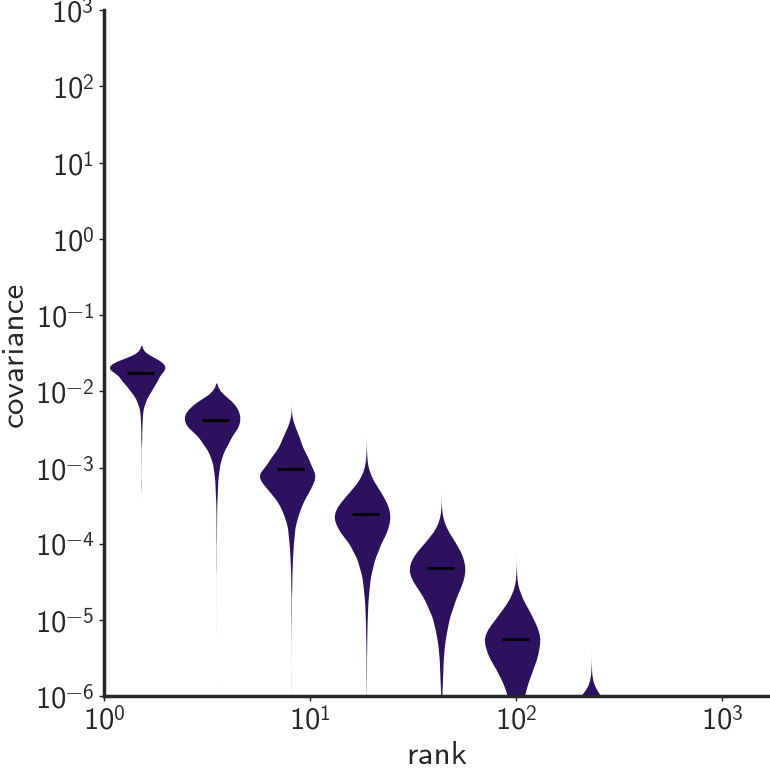

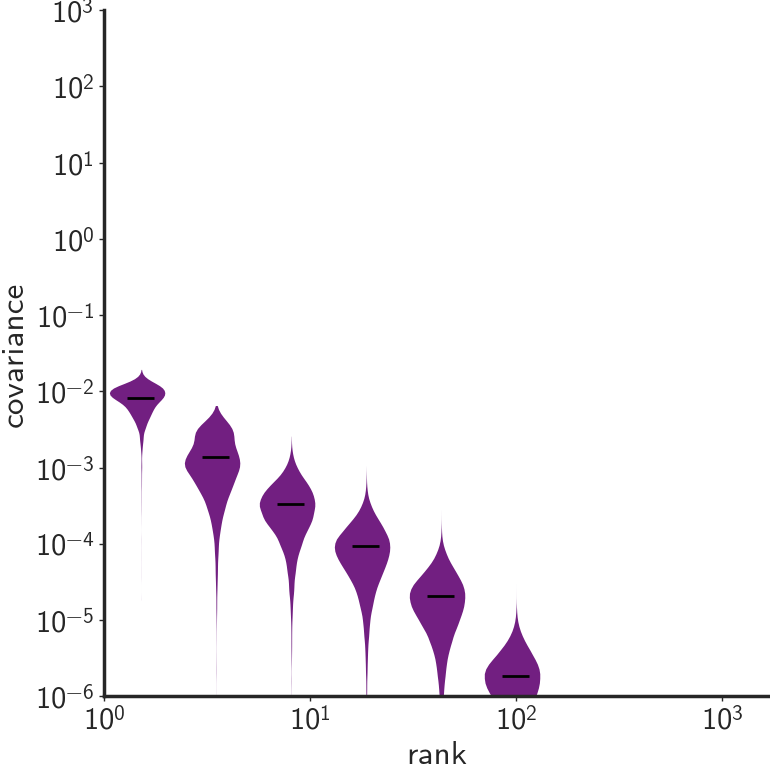

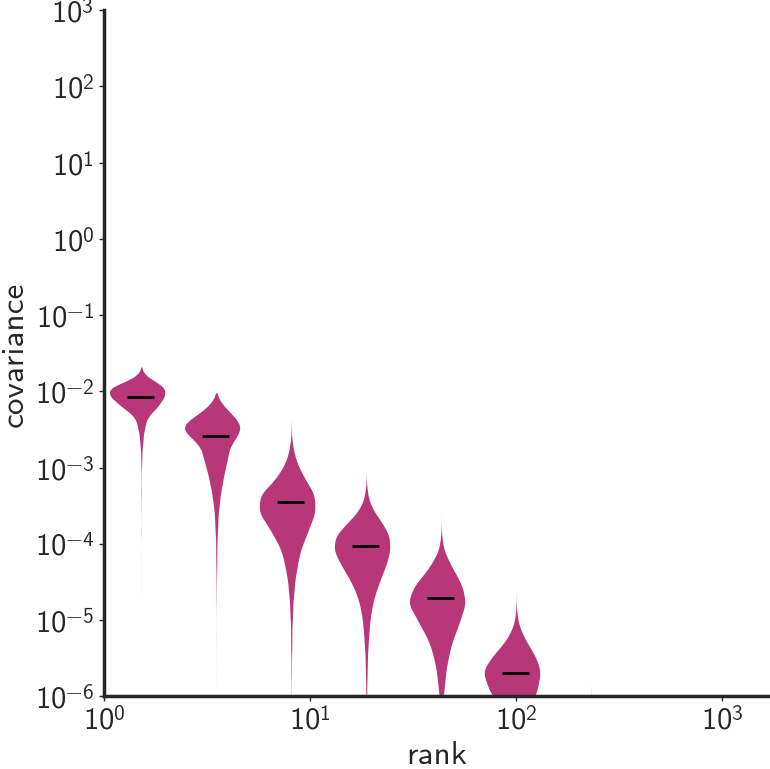

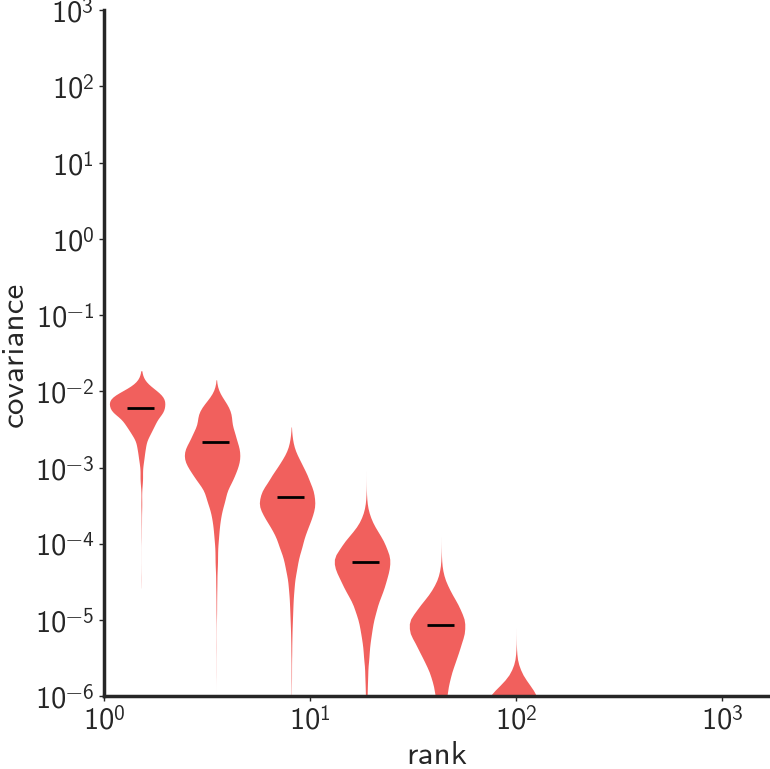

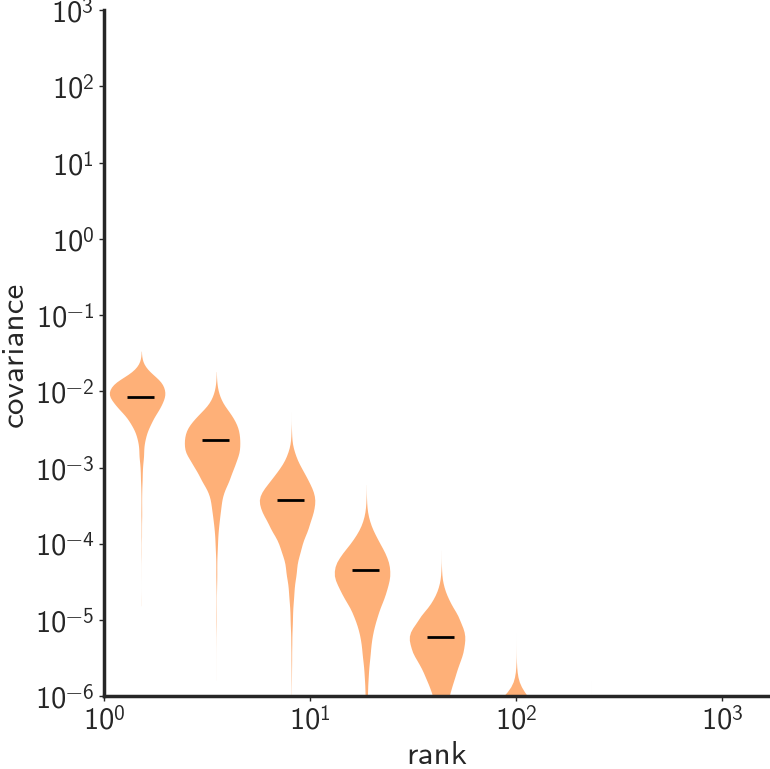

In [ ]:
import json

for roi in rois:
    with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
        voxel_dict = json.load(f)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Collect data
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for key in roi_spectra[roi].keys():
        spectrum = roi_spectra[roi][key]
        subject_pair = key.split('_')[0] + '_' + key.split('_')[1]
        spectrum = spectrum / voxel_dict[subject_pair] # normalize by number of voxels
        for bin, value in zip(bin_assignments, spectrum):
            all_binned_spectrum[bin].append(value)

    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in unique_bins]


    # Plot violins
    for idx, (pos, data) in enumerate(zip(unique_bins, all_binned_values)):
        original_data = data.copy()  # Keep original data including negatives
        data_positive = data[data > 0]  # Remove zeros or negative values for violin plot
        
        if len(data_positive) > 0:
            # Calculate the true mean from all data (including negatives)
            true_mean = np.mean(original_data)
            positive_mean = np.mean(data_positive)
            
            # Calculate shift needed to align with true mean
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            # Use exact data range
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin
            width = 0.3 * pos
            scaled_density = density / density.max() * width

            ax.fill_betweenx(x, pos - scaled_density, pos + scaled_density, 
                            alpha=1, color=roi_colors[rois.index(roi)])
            # Add mean line using true mean
            ax.hlines(true_mean, pos - width/2, pos + width/2, color='black', linewidth=2)
        

    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 1700)
    #ax.set_ylim(1e-10, 1e-1) if metric == 'cov' else ax.set_xlim(1e-3, 1e0)
    ax.set_ylim(1e-6, 1e3) if metric == 'cov' else ax.set_ylim(1e-3, 1e0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('rank')
    ax.set_ylabel('covariance' if metric == 'cov' else 'correlation')
    # ax.set_yticklabels([])
    # ax.set_yticks([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3])


    plt.show()
    # save as svg
    #plt.savefig(f'figure1_{roi}-{color}.svg', dpi=300, bbox_inches='tight')

Slope for occipital using first 5 bins: -1.7424384778476283
Slope for occipital using first 6 bins: -1.8715808870164452
Slope for occipital using first 7 bins: -2.061922616001744
Slope for occipital using first 8 bins: -2.1292648000819008
Slope for ventral using first 5 bins: -1.750822639700557
Slope for ventral using first 6 bins: -1.9070489026827855
Slope for ventral using first 7 bins: -2.141927992977354
Slope for ventral using first 8 bins: -2.203111182059955
Slope for temporal using first 5 bins: -1.850236759927337
Slope for temporal using first 6 bins: -1.9733544259966074
Slope for temporal using first 7 bins: -2.1268537945751373
Slope for temporal using first 8 bins: -2.163456940460733
Slope for semantic using first 5 bins: -1.996115334943287
Slope for semantic using first 6 bins: -2.1957371158846017
Slope for semantic using first 7 bins: -2.295739248249245
Slope for semantic using first 8 bins: -2.3144197547038
Slope for pmc using first 5 bins: -2.202701838895164
Slope for pmc 

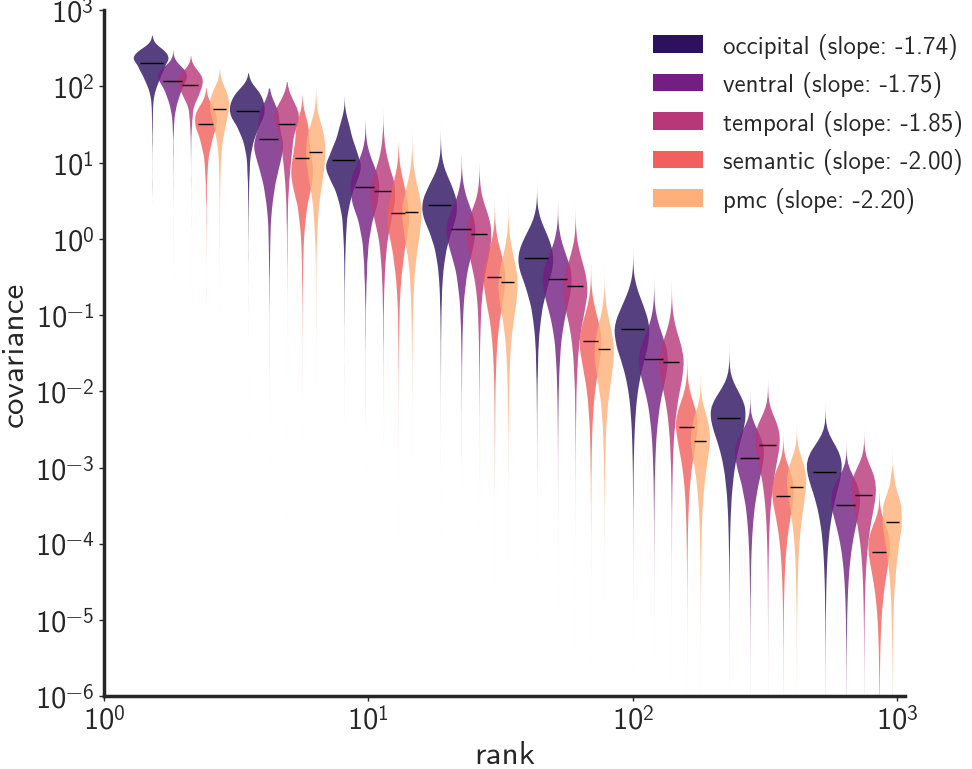

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
from scipy.optimize import curve_fit

# Create a single figure for all ROIs
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Define offset values for each ROI - using 0.2 as requested
roi_offsets = {roi: i * 0.2 for i, roi in enumerate(rois)}

# Calculate power law slopes
def fit_power_law(x_data, y_data):
    # Convert to log space for better fitting
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)
    
    # Remove any inf or nan values
    valid_indices = np.isfinite(log_x) & np.isfinite(log_y)
    log_x = log_x[valid_indices]
    log_y = log_y[valid_indices]
    
    # Simple linear fit in log space
    if len(log_x) > 1:
        coeffs = np.polyfit(log_x, log_y, 1)
        return coeffs[0]  # Slope in log-log space = power law exponent
    else:
        return np.nan

# Dictionary to store slopes for each ROI
slopes = {}

# Process each ROI
for roi_idx, roi in enumerate(rois):
    # Read voxel counts
    # with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
    #     voxel_dict = json.load(f)
    
    # Collect data for this ROI
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for key in roi_spectra[roi].keys():
        spectrum = roi_spectra[roi][key]
        subject_pair = key.split('_')[0] + '_' + key.split('_')[1]
        #spectrum = spectrum / voxel_dict[subject_pair]  # normalize by number of voxels
        for bin, value in zip(bin_assignments, spectrum):
            all_binned_spectrum[bin].append(value)
    
    # Calculate slope for this ROI
    ranks = []
    means = []
    for bin_val in unique_bins[:8]:  # Only use first 8 bins for slope calculation
        if len(all_binned_spectrum[bin_val]) > 0:
            ranks.append(bin_val)
            means.append(np.mean(all_binned_spectrum[bin_val]))
    
    if len(ranks) > 2:
        for i in range(5, 9):
            slope = fit_power_law(np.array(ranks[:i]), np.array(means[:i]))
            print(f"Slope for {roi} using first {i} bins: {slope}")
        slope = fit_power_law(np.array(ranks[:5]), np.array(means[:5])) # Use only first 5 bins for slope
        slopes[roi] = slope
    
    # Get data for violin plots - only use first 8 bins
    display_bins = unique_bins[:8]  # Only use first 8 bins for display
    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in display_bins]
    offset = roi_offsets[roi]
    
    # Plot violins with offset
    for idx, (pos, data) in enumerate(zip(display_bins, all_binned_values)):
        original_data = data.copy()
        data_positive = data[data > 0]  # Remove zeros or negative values
        
        if len(data_positive) > 0:
            # Calculate the true mean
            true_mean = np.mean(original_data)
            positive_mean = np.mean(data_positive)
            
            # Calculate shift needed
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin with position offset
            width = 0.3 * pos
            scaled_density = density / density.max() * width / 2  # Reduce width
            
            # Apply offset to position
            adjusted_pos = pos * (1 + offset)
            
            ax.fill_betweenx(x, adjusted_pos - scaled_density, adjusted_pos + scaled_density,
                            alpha=0.8, color=roi_colors[roi_idx])
            
            # Add mean line - simplified, thinner
            ax.hlines(true_mean, adjusted_pos - width/3, adjusted_pos + width/3, 
                     color='black', linewidth=1.0)

# Create custom legend with patches
handles = []
labels = []
for roi_idx, roi in enumerate(rois):
    patch = plt.Rectangle((0, 0), 1, 1, color=roi_colors[roi_idx])
    handles.append(patch)
    if roi in slopes:
        labels.append(f"{roi} (slope: {slopes[roi]:.2f})")
    else:
        labels.append(roi)

# Add legend
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

# Set scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 1070)  # Adjusted to only show up to the 8th bin range
#ax.set_ylim(1e-10, 1e-1)  # Adjust as needed for the metric
ax.set_ylim(1e-6, 1e3) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('rank')
ax.set_ylabel('covariance')  # Adjust based on your metric
plt.tight_layout()
#plt.savefig('combined_roi_violins.svg', dpi=300, bbox_inches='tight')
plt.show()